Imports

In [2]:
import cv2
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import os

Lecture 2 premières frames

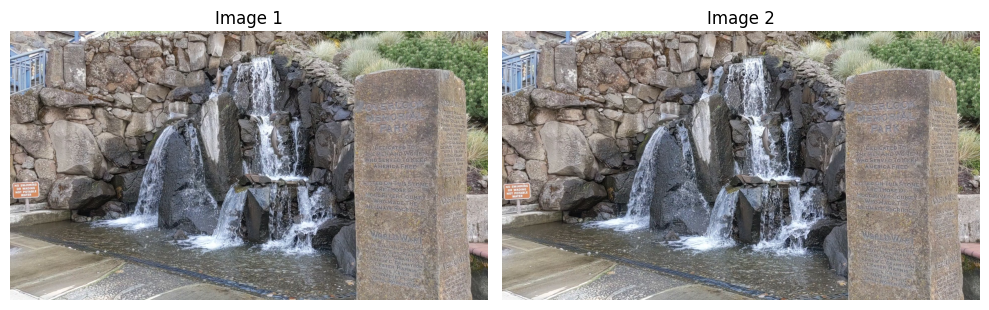

In [70]:
frame0 = cv2.imread('videos/fountain/frames/frame000.jpg')
frame1 = cv2.imread('videos/fountain/frames/frame001.jpg')
frame0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 ligne, 2 colonnes


axs[0].imshow(frame0)
axs[0].axis('off')  
axs[0].set_title('Image 1')

axs[1].imshow(frame1)
axs[1].axis('off')
axs[1].set_title('Image 2')

plt.tight_layout()
plt.show()

Extraction points intérêts

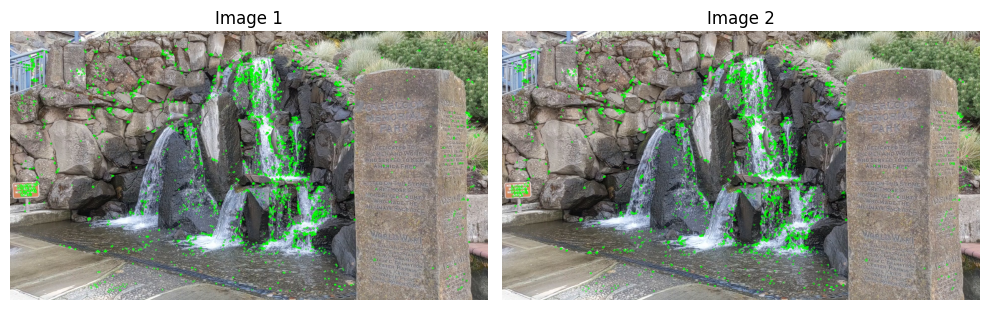

In [71]:
orb = cv2.ORB_create(nfeatures = 5000,nlevels = 10)
keypoints0 = orb.detect(frame0, None)
keypoints0, descriptors0 = orb.compute(frame0, keypoints0)

image_with_keypoints_frame0 = cv2.drawKeypoints(frame0, keypoints0, None, color=(0, 255, 0))

keypoints1 = orb.detect(frame1, None)
keypoints1, descriptors1 = orb.compute(frame0, keypoints1)

image_with_keypoints_frame1 = cv2.drawKeypoints(frame0, keypoints1, None, color=(0, 255, 0))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 ligne, 2 colonnes


axs[0].imshow(image_with_keypoints_frame0)
axs[0].axis('off')  
axs[0].set_title('Image 1')

axs[1].imshow(image_with_keypoints_frame1)
axs[1].axis('off')
axs[1].set_title('Image 2')

plt.tight_layout()
plt.show()

Mise en correspondance des points d'intérêts

5000


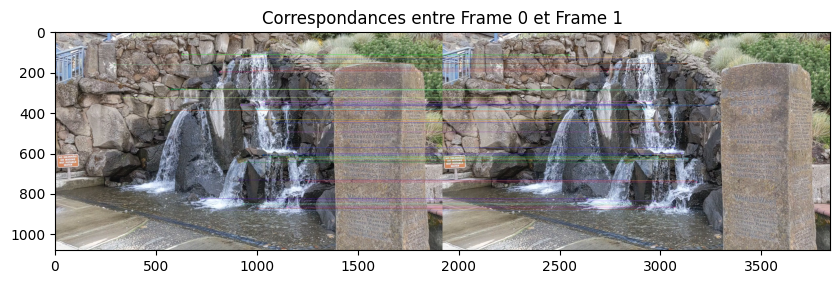

In [72]:
bf = cv2.BFMatcher()
matches = bf.match(descriptors0,descriptors1)
print(len(matches))
matches = sorted(matches, key = lambda x:x.distance)
image_match = cv2.drawMatches(frame0,keypoints0,frame1,keypoints1,matches[:50],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 5))
plt.imshow(image_match)
plt.title("Correspondances entre Frame 0 et Frame 1")
plt.show()

Mettre en formes les points détectés

In [73]:
kp_ref = keypoints0
kp_mov = keypoints1

src_pts = np.float32([ kp_ref[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
dst_pts = np.float32([ kp_mov[m.trainIdx].pt for m in matches]).reshape(-1,1,2)


Recalage similarité

In [74]:
matrix_s, inliers_s = cv2.estimateAffinePartial2D(src_pts,dst_pts) # matrice 3x2 car il n'influence pas dans le monde 3D elle ne fais que : translation,rotation,symetrie,cisaillement,mise à l'échelle
matrix_a, inliers_a = cv2.estimateAffine2D(src_pts,dst_pts)
matrix_h, inliers_h = cv2.findHomography(src_pts,dst_pts,cv2.RANSAC,5.0)

# les termes de la dernière colonnes sont ceux de la translation
matrix_s = np.vstack((matrix_s, [0,0,1]))
matrix_a = np.vstack((matrix_a, [0,0,1]))

print("Matrix Similarité : ",matrix_s)
print('*'*100)
print("Matrix Affine : ",matrix_a)
print('*'*100)
print("Matrix Homography : ",matrix_h)

Matrix Similarité :  [[ 9.99798879e-01  1.87255745e-03 -2.30667118e+00]
 [-1.87255745e-03  9.99798879e-01  3.62792894e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
****************************************************************************************************
Matrix Affine :  [[ 9.99278859e-01  5.18175746e-03 -3.06831402e+00]
 [-3.67439682e-03  1.00178689e+00  5.21676650e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
****************************************************************************************************
Matrix Homography :  [[ 9.60830075e-01 -1.68846680e-02  2.55046451e+01]
 [-4.29661232e-03  9.70054347e-01  9.00590753e+00]
 [-1.32482212e-05 -1.50842147e-05  1.00000000e+00]]


Application des matrices

In [75]:
maxHeight,maxWidth,_ = frame1.shape
rec_s = cv2.warpPerspective(frame1,matrix_s,(maxWidth, maxHeight))
rec_a = cv2.warpPerspective(frame1,matrix_a,(maxWidth, maxHeight))
rec_h = cv2.warpPerspective(frame1,matrix_h,(maxWidth, maxHeight))

In [76]:
def mse(im1,im2,crop) :
    maxHeight,maxWidth,_ = im1.shape
    im1_cropped = im1[crop:maxHeight-crop, crop:maxWidth-crop]
    im2_cropped = im2[crop:maxHeight-crop, crop:maxWidth-crop]
    diff = abs(im1_cropped-im2_cropped)
    mean = 0
    nmb = 0
    for x in range(maxHeight-2*crop):
        for y in range(maxWidth-2*crop):
            for rgb in range(3):
                mean += diff[x,y,rgb]
                nmb+=1
    return mean/nmb


C:\Users\gaell\AppData\Local\Temp\ipykernel_21152\1942745282.py:11: RuntimeWarning: overflow encountered in scalar add
  mean += diff[x,y,rgb]


mse_crop :  2.3784355179704015e-05
mse_s_crop :  5.2193446088794925e-05
mse_a_crop :  4.6687808315715294e-05
mse_h_crop :  1.80584918957012e-05
******************************************************************************************************************************************************


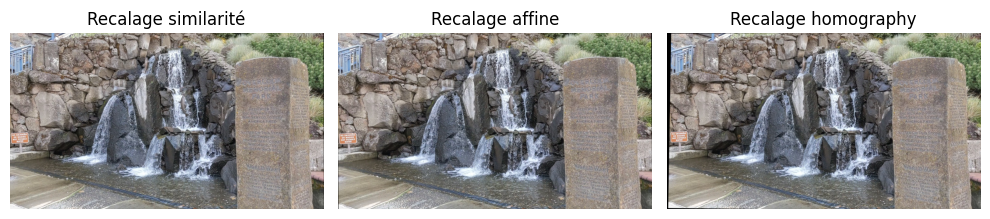

In [77]:
crop = 100

mse_crop = mse(frame1,frame0,crop)
mse_s_crop = mse(rec_s,frame0,crop)
mse_a_crop = mse(rec_a,frame0,crop)
mse_h_crop = mse(rec_h,frame0,crop)

print('mse_crop : ',mse_crop)
print('mse_s_crop : ',mse_s_crop)
print('mse_a_crop : ',mse_a_crop)
print('mse_h_crop : ',mse_h_crop)

print('*'*150)


fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # 1 ligne, 2 colonnes


axs[0].imshow(rec_s)
axs[0].axis('off')  
axs[0].set_title('Recalage similarité')

axs[1].imshow(rec_a)
axs[1].axis('off')
axs[1].set_title('Recalage affine')

axs[2].imshow(rec_h)
axs[2].axis('off')
axs[2].set_title('Recalage homography')

plt.tight_layout()
plt.show()

Video

In [3]:
folder_path = 'videos/road/frames/'

# Obtenir tous les fichiers dans le dossier
files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
print(files)
print(len(files))

['frame000.jpg', 'frame001.jpg', 'frame002.jpg', 'frame003.jpg', 'frame004.jpg', 'frame005.jpg', 'frame006.jpg', 'frame007.jpg', 'frame008.jpg', 'frame009.jpg', 'frame010.jpg', 'frame011.jpg', 'frame012.jpg', 'frame013.jpg', 'frame014.jpg', 'frame015.jpg', 'frame016.jpg', 'frame017.jpg', 'frame018.jpg', 'frame019.jpg', 'frame020.jpg', 'frame021.jpg', 'frame022.jpg', 'frame023.jpg', 'frame024.jpg', 'frame025.jpg', 'frame026.jpg', 'frame027.jpg', 'frame028.jpg', 'frame029.jpg', 'frame030.jpg', 'frame031.jpg', 'frame032.jpg', 'frame033.jpg', 'frame034.jpg', 'frame035.jpg', 'frame036.jpg', 'frame037.jpg', 'frame038.jpg', 'frame039.jpg', 'frame040.jpg', 'frame041.jpg', 'frame042.jpg', 'frame043.jpg', 'frame044.jpg', 'frame045.jpg', 'frame046.jpg', 'frame047.jpg', 'frame048.jpg', 'frame049.jpg', 'frame050.jpg', 'frame051.jpg', 'frame052.jpg', 'frame053.jpg', 'frame054.jpg', 'frame055.jpg', 'frame056.jpg', 'frame057.jpg', 'frame058.jpg', 'frame059.jpg', 'frame060.jpg', 'frame061.jpg', 'frame0

de

In [4]:
folder_path_output_s = 'videos/road/frames_rec_s'
if not os.path.exists(folder_path_output_s):
    os.makedirs(folder_path_output_s)

# folder_path_output_a = 'videos/fountain/frames_rec_a'
# if not os.path.exists(folder_path_output_a):
#     os.makedirs(folder_path_output_a)

# folder_path_output_h = 'videos/fountain/frames_rec_h'
# if not os.path.exists(folder_path_output_h):
#     os.makedirs(folder_path_output_h)

orb = cv2.ORB_create(nfeatures = 1000,nlevels = 8)
bf = cv2.BFMatcher()


frame0 = cv2.imread(os.path.join(folder_path,files[0]))
frame1 = frame0
maxHeight,maxWidth,_ = frame1.shape

frames_rec_s = [frame0]
# frames_rec_a = [frame0]
# frames_rec_h = [frame0]
# files = files[:50]
print('tailles files : ',len(files))
for i in range(1,len(files)):
    
    frame0 = np.copy(frame1)
    frame1 = cv2.imread(os.path.join(folder_path,files[i]))
    
    keypoints0 = orb.detect(frame0, None)
    keypoints0, descriptors0 = orb.compute(frame0, keypoints0)

    # image_with_keypoints_frame0 = cv2.drawKeypoints(frame0, keypoints0, None, color=(0, 255, 0))

    keypoints1 = orb.detect(frame1, None)
    keypoints1, descriptors1 = orb.compute(frame1, keypoints1)
    
    matches = bf.match(descriptors1,descriptors0)
    matches = sorted(matches, key = lambda x:x.distance)
    # image_match = cv2.drawMatches(frame0,keypoints0,frame1,keypoints1,matches[:50],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    kp_ref = keypoints0
    kp_mov = keypoints1
    src_pts = np.float32([ kp_ref[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_mov[m.queryIdx].pt for m in matches]).reshape(-1,1,2)

    

    matrix_s, inliers_s = cv2.estimateAffinePartial2D(dst_pts,src_pts) # matrice 3x2 car il n'influence pas dans le monde 3D elle ne fais que : translation,rotation,symetrie,cisaillement,mise à l'échelle
    # matrix_a, inliers_a = cv2.estimateAffine2D(dst_pts,src_pts)
    # matrix_h, inliers_h = cv2.findHomography(dst_pts,src_pts,cv2.RANSAC,5.0)
    # print(matrix_s)
    matrix_s = np.vstack((matrix_s, [0,0,1]))
    # matrix_a = np.vstack((matrix_a, [0,0,1]))


    rec_s = cv2.warpPerspective(frame1,matrix_s,(maxWidth, maxHeight))
    # rec_a = cv2.warpPerspective(frame1,matrix_a,(maxWidth, maxHeight))
    # rec_h = cv2.warpPerspective(frame1,matrix_h,(maxWidth, maxHeight))
    image_save_path_s = os.path.join(folder_path_output_s, files[i])
    # image_save_path_a = os.path.join(folder_path_output_a, files[i])
    # image_save_path_h = os.path.join(folder_path_output_h, files[i])

    # Sauvegarder l'image dans le dossier
    plt.imsave(image_save_path_s, rec_s)
    # plt.imsave(image_save_path_a, rec_a)
    # plt.imsave(image_save_path_h, rec_h)

    frames_rec_s.append(rec_s)
    # frames_rec_a.append(rec_a)
    # frames_rec_h.append(rec_h)

    frame1 = np.copy(rec_s)



tailles files :  437


Transformation en vidéo

In [5]:
# Create mp4 from jpg list
h,w = maxHeight,maxWidth

path_out = "videos/road/"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
vidwriter = cv2.VideoWriter(path_out + 'output_s.mp4', fourcc, 24,(w,h))

for frame in frames_rec_s:
    vidwriter.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
vidwriter.release()

# vidwriter = cv2.VideoWriter(path_out + 'output_a.mp4', fourcc, 24,(w,h))
# for frame in frames_rec_a:
#     vidwriter.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
# vidwriter.release()

# vidwriter = cv2.VideoWriter(path_out + 'output_h.mp4', fourcc, 24,(w,h))
# for frame in frames_rec_h:
#     vidwriter.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
# vidwriter.release()
